In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Champagne Sales Data

In [8]:
#read data
df = pd.read_csv(r"C:\Users\Volkan ARIKAN\Desktop\champagne.csv",index_col=0, squeeze=True)

In [9]:
#infer the frequency of the data
df = df.asfreq(pd.infer_freq(df.index))

In [20]:
start_date = datetime(1964,1,1)
end_date = datetime(1972,9,1)

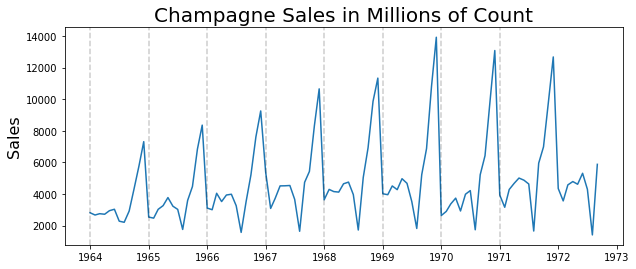

In [45]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Champagne Sales in Millions of Count', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = df.diff()[1:]

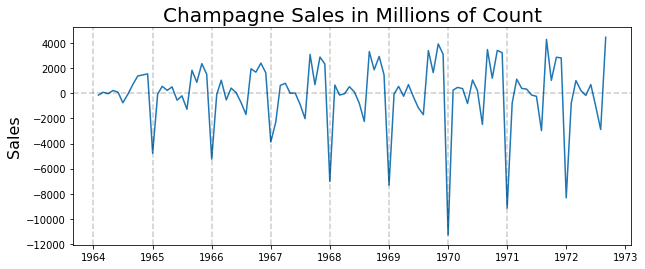

In [47]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Champagne Sales in Millions of Count', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

C:\Users\Volkan ARIKAN\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<BarContainer object of 20 artists>

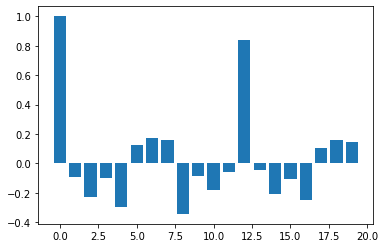

In [24]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

C:\Users\Volkan ARIKAN\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<BarContainer object of 15 artists>

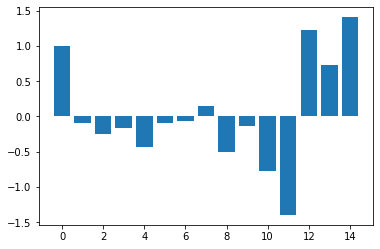

In [25]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [26]:
train_end = datetime(1971,9,1)
test_end = datetime(1972,9,1)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [27]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [29]:
#fit the model
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time:', end - start)

C:\Users\Volkan ARIKAN\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Model Fitting Time: 2.407012462615967


In [30]:
#summary of the model
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 12)   Log Likelihood                -785.070
Date:                            Thu, 15 Oct 2020   AIC                           1576.140
Time:                                    15:16:42   BIC                           1583.705
Sample:                                01-01-1964   HQIC                          1579.193
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9566      0.037     26.010      0.000       0.885       1.029
ma.S.L12      -0.2667      0.121   

In [31]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

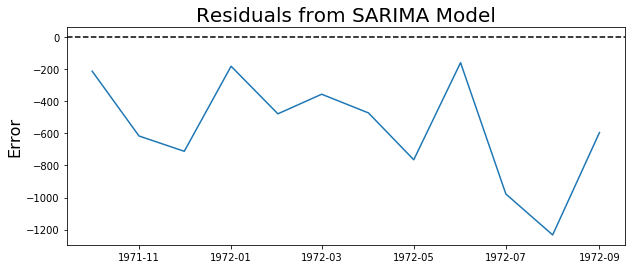

In [32]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

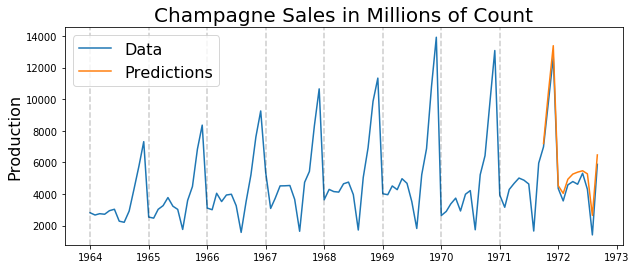

In [48]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Champagne Sales in Millions of Count', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1581


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 644.2325833187112


# Using the Rolling Forecast Origin

In [60]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=0)

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [61]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

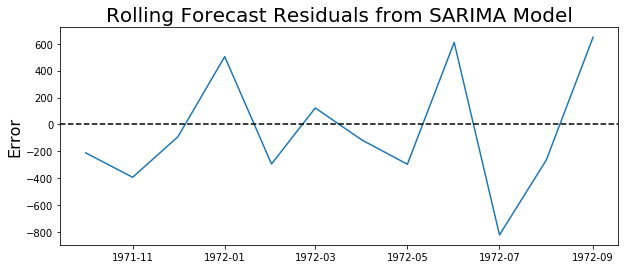

In [62]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

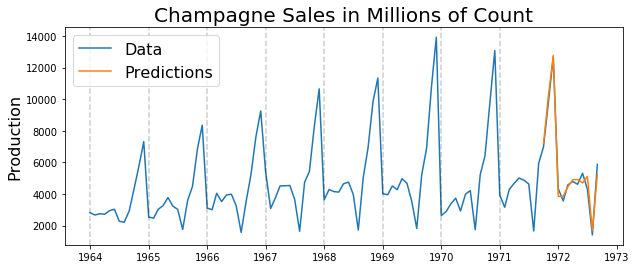

In [63]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Champagne Sales in Millions of Count', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [64]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0828


In [65]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 427.78898614464896
